In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mlp
import glob
from tqdm import tqdm
from scipy.stats import t as student
from matplotlib.ticker import FormatStrFormatter

import seaborn as sns
import warnings; warnings.filterwarnings(action='once')
plt.style.use('seaborn-whitegrid')
sns.set_style("white",rc={
    'xtick.bottom': True,
    'ytick.left': True,
})
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.width'] = 1

In [2]:
# COUNTRY INFORMATION: country, capital, country folder, 
# dept_ with columns 'Dept' & 'Pop', area_ with 'Dept' & 'Area', region_ with 'Dept' & 'Region'
country='FR'  #ISO 2
country_sp='FRA'  #ISO 3
capital='Paris'

COLOCATION='C:/Users/piero/Documents/PCS/INTERNSHIP/DATA/COLOCATION/'
path_array=glob.glob(str(COLOCATION)+str(country_sp)+str('/')+str(country_sp)+str('/*/*.csv'))

In [3]:
path='C:/Users/piero/Documents/PCS/INTERNSHIP/DATA/FRA/FRA/2378852883928146_2021-12-23_2022-02-21_csv/2378852883928146_2022-01-18.csv'
data = pd.read_csv(path, delimiter=',',engine='python')
FR_data=data[data['country']==country]
FR_data_Paris=FR_data[FR_data['polygon1_name']==capital]
polygons=FR_data_Paris.loc[:,'polygon2_name']

path_dept=str(COLOCATION)+str('0_population_COUNTRY/dept_')+str(country_sp)+str('.csv')
dept = pd.read_csv(path_dept, delimiter=',',engine='python')

dict ={}
for p, pol in enumerate (polygons):
    rep=pol.replace('é', 'e')
    rep_=rep.replace('è','e')
    rep__=rep_.replace('ô','o')
    dict[pol]=rep__.upper()

In [4]:
# RUN HERE
with open(str(COLOCATION)+str('1_Rij_vec_COUNTRY/Rij_vec_sp_imm_')+str(country_sp)+str('.csv'), 'rb') as f:
    Rij_vec = np.load(f)
cal=[]
for path_ in (path_array[:(90)]):
    cal.append(path_[-14:-4])
calendar=np.array(cal)

## SEIIR model

In [5]:
pop_vec=[]
for p,pp in enumerate (polygons):
    pop=dept[dept['dept name']==dict[pp]].loc[:,'pop 2020'].iloc[0]
    pop_vec.append(pop)
pop_vec=np.array(pop_vec)
tot_pop=np.sum(pop_vec)
N=len(polygons)

In [6]:
params={'beta': 0.00068/9.1, 'mu': 1/(7+2.1), 'beta_I' : 0.51, 'epsilon' : 1/3.7, 'p_sc' : 0.32}
delta_T=1
N0=pop_vec
a=np.where(calendar=='2021-02-02')[0][0]
R_interval=[Rij_vec[a-1],Rij_vec[a],Rij_vec[a+1],Rij_vec[a+2]]
Q_2021_02_02=np.mean(R_interval,0)

def SEIIR_model (I0, E0=np.zeros(len(polygons)), R0=np.zeros(len(polygons)), T=7*len(Rij_vec),Q=Q_2021_02_02, pars=params):
    
    # arrays to store number of individuals in departments across time
    S=np.zeros((T+1,len(polygons)))
    E=np.zeros((T+1,len(polygons)))
    I=np.zeros((T+1,len(polygons)))
    R=np.zeros((T+1,len(polygons)))
    I_inc=np.zeros((T+1,len(polygons)))
    N=N0.copy()

    # present time variables
    Et=E0.copy().astype('int32')
    It=I0.copy().astype('int32')
    Rt=R0.copy().astype('int32')
    St=(N-Rt-It).astype('int32')
    
    # store t=0 variables
    E[0]=Et.copy()
    I[0]=It.copy()
    R[0]=Rt.copy()
    S[0]=St.copy()
    I_inc[0]=It
    
    # probabilities associated to transitions with given rate
    p_mu=1-np.exp(-pars['mu']*delta_T)
    p_epsilon=1-np.exp(-pars['epsilon']*delta_T)
    
    for t in range(T):
        
        R_new=np.random.binomial(n=It, p=p_mu)
        It-=R_new
        Rt+=R_new
        
        I_new=np.random.binomial(n=Et,p=p_epsilon)
        Et-=I_new
        It+=I_new
        I_inc[t+1]=I_new
        
        p_beta=np.dot( Q , pars['beta']*It)/N
        proba_beta=np.ones(len(polygons))-np.exp(-p_beta*delta_T)
        E_new=np.random.binomial(n=St, p=proba_beta)
        Et+=E_new
            
        St=(N-Rt-It-Et).astype('int32')
        E[t+1]=Et.copy()
        I[t+1]=It.copy()
        R[t+1]=Rt.copy()
        S[t+1]=St.copy()

    return ([S,E,I,R,I_inc])

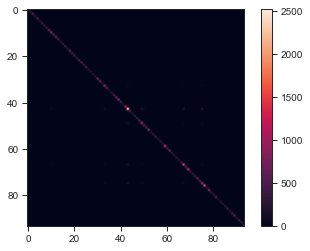

In [7]:
plt.imshow(Q_2021_02_02)
_=plt.colorbar()

## Algebra

In [8]:
Rfrance=1.5
beta=Rfrance*params['mu']/(np.sort(np.linalg.eig(Q_2021_02_02)[0])[-1])
print (beta)
params['beta']=beta
eff_beta=params['beta']*(np.sort(np.linalg.eig(Q_2021_02_02)[0])[-1])
print(eff_beta)

6.247338285239727e-05
0.16483516483516483


In [9]:
w,vl,vr=scipy.linalg.eig(Q_2021_02_02,left=True)
v=[]
z=[]
for u,wu in enumerate (w):
    v.append(vr[:,u]/np.sum(vr[:,u]))
    z.append(vl[:,u]/np.sum(vl[:,u]))
v=np.array(v)
z=np.array(z)
max_v=v[w.argmax()] 
max_z=z[w.argmax()]
projectors=np.array([[[v[alpha][j]*z[alpha][k] for k in range(N)] for j in range(N)] for alpha in range(N)])

#-----------------------------------------------------------------

for i in range (1,10):
    if(max_v[0]<0):
        v[np.argsort(w)[-i]]*=(-1)
    if(max_z[0]<0):
        z[np.argsort(w)[-i]]*=(-1)
    v_rank=v[np.argsort(w)[-i]]
    print(polygons.iloc[v_rank.argmax()],np.sort(w)[-i])
print('-')
for i in range (1,10):
    print(polygons.iloc[np.argsort(max_v)[-i]],np.sort(max_v)[-i])

Paris (2638.486301031795+0j)
Alpes-Maritimes (1619.7209571814255+0j)
Hauts-de-Seine (1468.282860878924+0j)
Rhône (1342.9748778329238+0j)
Bouches-du-Rhône (1209.9070470804963+0j)
Seine-Saint-Denis (1070.4240842021575+0j)
Val-de-Marne (998.481629137559+0j)
Val-d'Oise (954.9537039827381+0j)
Var (850.7613926802685+0j)
-
Paris 0.6187106968503224
Hauts-de-Seine 0.10709834476249662
Seine-Saint-Denis 0.09158953188934467
Val-de-Marne 0.06054107246019619
Val-d'Oise 0.035879144646901284
Essonne 0.023547913356975984
Yvelines 0.02311975177280934
Seine-et-Marne 0.018628095159668876
Oise 0.003250726308339194


## Simulation

In [10]:
init_cases=100

Bordeaux=np.where(polygons=='Gironde')[0][0]
HDS=np.where(polygons=='Hauts-de-Seine')[0][0]
AM=np.where(polygons=='Alpes-Maritimes')[0][0]
PARIS=np.where(polygons=='Paris')[0][0]

HDS_0,AM_0,PARIS_0=np.zeros(N),np.zeros(N),np.zeros(N)
HDS_0[HDS]=init_cases
AM_0[AM]=init_cases
PARIS_0[PARIS]=init_cases

pop_like_0=np.array([round(init_cases*(np.array(pop_vec)/np.sum(pop_vec))[i]) for i in range (N)])
np.sum(pop_like_0)

99

In [18]:
sim_len=110

In [ ]:
params['beta']=beta

I_0=np.zeros((2,N))
I_0[0]=np.array(PARIS_0)
I_0[1]=np.array(pop_like_0)
E_0=I_0.copy()
n=10000

SOL_panel_check=np.zeros((2,n,5,sim_len+1,N),dtype='int32')
for y,Y in enumerate (I_0):
    I0_=Y.copy()
    E0_=Y.copy()
    for s in tqdm(range(n)):
        SOL_panel_check[y][s]=(np.array(SEIIR_model(I0_,E0=E0_,Q=Q_2021_02_02,T=sim_len)))

In [ ]:
np.shape(SOL_panel_check)

(2, 10000, 5, 111, 94)

## Reproductive Numbers

In [ ]:
d_print = [[np.sum(SOL_panel_check[ic,r,4],axis=1)[t],ic,r,t] for ic in range(len(SOL_panel_check)) for r in range(len(SOL_panel_check[0])) for t in range(len(SOL_panel_check[0,0,0]))] 
df_print = pd.DataFrame(data=d_print,columns=['incidence','IC','run','time'])
display(df_print[:4])
df_print.to_csv('C:/Users/piero/Documents/PHD/eugenio/new_metapop/SIMULS/Fig1dot0_inc_new_.csv',sep=',')

incidence  IC  run  time
0        100   0    0     0
1         30   0    0     1
2         19   0    0     2
3         37   0    0     3

In [ ]:
d_print_zproj = [[len(polygons)*np.dot(SOL_panel_check[ic,r,4,t],max_z),ic,r,t] for ic in range(len(SOL_panel_check)) for r in range(len(SOL_panel_check[0])) for t in range(len(SOL_panel_check[0,0,0]))] 
df_print_zproj = pd.DataFrame(data=d_print_zproj,columns=['incidence','IC','run','time'])
display(df_print_zproj[:4])
df_print_zproj.to_csv('C:/Users/piero/Documents/PHD/eugenio/new_metapop/SIMULS/Fig1dot0_inc_zproj_new_.csv',sep=',')

incidence  IC  run  time
0  4937.920326   0    0     0
1  1481.376098   0    0     1
2   850.445740   0    0     2
3  1497.053695   0    0     3

In [ ]:
def s_calc_proj (SOL,Rij=Q_2021_02_02):
    s_=np.zeros((len(SOL),len(SOL[0]),len(SOL[0][0][0]),len(SOL[0][0][0][0])))
    S_=np.zeros((len(SOL),len(SOL[0]),len(SOL[0][0][0])))
    S_zproj_=np.zeros((len(SOL),len(SOL[0]),len(SOL[0][0][0])))
    for ic in tqdm(range (len(SOL))):
        for run in range (len(SOL[0])):
            for t in range (len(SOL[0][0][0])):
                a=SOL[ic][run][2][t].astype(float)
                b=np.sum(SOL[ic][run][2][t],axis=0).astype(float)
                b_second=np.dot(SOL[ic][run][2][t],max_z).astype(float)
                c=np.divide(a, b, out=np.zeros_like(a), where=b!=0)
                c_second=np.divide(a, b_second, out=np.zeros_like(a), where=b_second!=0)
                sS=np.sum((Rij*(np.array([SOL[ic,run,0,t]*c/pop_vec]*len(polygons)))) ,axis=1)
                sS_second=np.sum((Rij*(np.array([SOL[ic,run,0,t]*c_second/pop_vec]*len(polygons)))) ,axis=1)
                s_[ic,run,t]=np.divide(sS,c,out=np.zeros_like(sS),where=c!=0)
                S_[ic,run,t]=np.sum(sS,axis=0)
                S_zproj_[ic,run,t]=np.dot(sS_second,max_z)
    return [s_,S_,S_zproj_]

s_S = s_calc_proj(SOL_panel_check)
s_check=np.array(s_S[0])
S_check=np.array(s_S[1])
S_zproj_check=np.array(s_S[2])

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [10:58<00:00, 329.40s/it]


In [ ]:
with open('C:/Users/piero/Documents/PHD/eugenio/new_metapop/SIMULS/S_Fig1dot0_1k_new_.csv', 'wb') as f:
    np.save(f, S_check)
with open('C:/Users/piero/Documents/PHD/eugenio/new_metapop/SIMULS/S_zproj_Fig1dot0_1k_new_.csv', 'wb') as f:
    np.save(f, S_zproj_check)
with open('C:/Users/piero/Documents/PHD/eugenio/new_metapop/SIMULS/si_Fig1dot0_1k_new_.csv', 'wb') as f:
    np.save(f, s_check)

## ws

In [ ]:
def ws_calc (SOL,Q=Q_2021_02_02):
    max_ws=[[[np.amax(np.linalg.eig(Q*(np.array([SOL[ic,run,0,t]/pop_vec]*len(polygons))))[0]) for t in range (len(SOL[0][0][0]))]for run in range (len(SOL[0]))]for ic in tqdm(range(len(SOL)))]
    return (max_ws)

max_w=ws_calc(SOL_panel_check)

  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [58:04<58:04, 3484.76s/it]

In [ ]:
np.shape(max_w)

(2, 5000, 121)

In [ ]:
with open('C:/Users/piero/Documents/PHD/eugenio/new_metapop/SIMULS/maxw_Fig1dot0_1k_new_.csv', 'wb') as f:
    np.save(f, max_w)

## EpiEstim

In [16]:
S_df_check = pd.read_csv('C:/Users/piero/Documents/PHD/eugenio/new_metapop/SIMULS/Fig1dot0_epiS_new_.csv',sep=',',engine='python')
S_df_check_zproj = pd.read_csv('C:/Users/piero/Documents/PHD/eugenio/new_metapop/SIMULS/Fig1dot0_epiS_zproj_new_.csv',sep=',',engine='python')
display(S_df_check[:5])

S  IC  run  time
0       NaN   0    0     0
1       NaN   0    0     1
2       NaN   0    0     2
3       NaN   0    0     3
4  1.843744   0    0     4

In [19]:
S_epi_check=np.zeros((len(S_check),len(S_check[0]),sim_len-6))
S_epi_check_zproj=np.zeros((len(S_check),len(S_check[0]),sim_len-6))
for ic in range(len(S_check)):
    for r in range(len(S_check[0])):
        a=S_df_check[S_df_check['IC']==ic]
        a_zproj=S_df_check_zproj[S_df_check_zproj['IC']==ic]
        S_epi_check[ic][r]=a[a['run']==r].iloc[:,0]
        S_epi_check_zproj[ic][r]=a_zproj[a_zproj['run']==r].iloc[:,0]

In [20]:
with open('C:/Users/piero/Documents/PHD/eugenio/new_metapop/SIMULS/S_epi_Fig1dot0_1k_new_.csv', 'wb') as f:
    np.save(f, S_epi_check)
with open('C:/Users/piero/Documents/PHD/eugenio/new_metapop/SIMULS/S_epi_zproj_Fig1dot0_1k_new_.csv', 'wb') as f:
    np.save(f, S_epi_check_zproj)

## Read

In [21]:
with open('C:/Users/piero/Documents/PHD/eugenio/new_metapop/SIMULS/S_Fig1dot0_1k_new_.csv', 'rb') as f:
    S_check=np.load(f)
with open('C:/Users/piero/Documents/PHD/eugenio/new_metapop/SIMULS/S_zproj_Fig1dot0_1k_new_.csv', 'rb') as f:
    S_zproj_check=np.load(f)
with open('C:/Users/piero/Documents/PHD/eugenio/new_metapop/SIMULS/si_Fig1dot0_1k_new_.csv', 'rb') as f:
    s_check=np.load(f)

In [22]:
with open('C:/Users/piero/Documents/PHD/eugenio/new_metapop/SIMULS/maxw_Fig1dot0_1k_new_.csv', 'rb') as f:
    max_w = np.load(f)

In [23]:
with open('C:/Users/piero/Documents/PHD/eugenio/new_metapop/SIMULS/S_epi_Fig1dot0_1k_new_.csv', 'rb') as f:
    S_epi_check=np.load(f)
with open('C:/Users/piero/Documents/PHD/eugenio/new_metapop/SIMULS/S_epi_zproj_Fig1dot0_1k_new_.csv', 'rb') as f:
    S_epi_check_zproj=np.load(f)

In [28]:
max_w=np.ones_like(S_check)*Rfrance/(params['beta']/params['mu'])
print(np.shape(S_check),np.shape(S_zproj_check),np.shape(s_check),np.shape(max_w))

(2, 10000, 111) (2, 10000, 111) (2, 10000, 111, 94) (2, 10000, 111)


(0.0, 3.0)

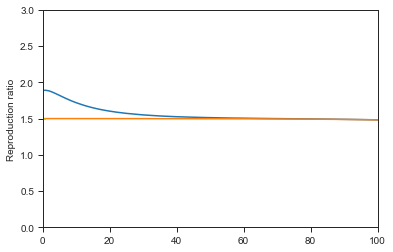

In [25]:
plt.plot(params['beta']/params['mu']*np.percentile(S_check[0],50,axis=0),label=r'$R^{obs}$')
plt.plot(params['beta']/params['mu']*np.percentile(S_zproj_check[0],50,axis=0),label=r'$R^{corr}}$')
#plt.plot(np.percentile(S_epi_check[0],50,axis=0),label=r'$R^{obs}$')
#plt.plot(np.percentile(S_epi_check_zproj[0],50,axis=0),label=r'$R^{corr}}$')
plt.hlines(Rfrance,0,1,color='y')
plt.ylabel('Reproduction ratio')
plt.xlim([0,100])
plt.ylim([0,3])

## Figures

In [29]:
def S_panel_plotter_Fig1(S,S_Epi,s,max_w_=max_w,dim1=2,dim2=2,end=[101,101],start=0,save=False,name='a',tit=None):
    
    fig,ax = plt.subplots(dim1,dim2,figsize=(16,9),dpi=300)
    c=['darkorange','tab:blue','dimgrey','r','orchid','coral']
    x=np.linspace(0,len(S[0,0]),len(S[0,0]))
    pref=params['beta']/params['mu']
    fig.suptitle(tit,fontsize=20 )
    sh=14
    cp=sns.color_palette('gray_r',len(polygons))#+25)[:-25]
    cp1=cp[:-25]
    cp2=cp[-25:]
    cp=np.concatenate((cp2,cp1))

    for i,a in enumerate (ax.reshape(-1)[:2]): #(1/(np.linalg.norm(max_v)**2))*
        m=pref*np.percentile(S[i],50,axis=0)
        CI=pref*np.array((np.percentile(S[i],2.5,axis=0),np.percentile(S[i],97.5,axis=0)))
        m_Epi=np.percentile(S_Epi[i],50,axis=0)
        CI_Epi=np.array((np.percentile(S_Epi[i],2.5,axis=0),np.percentile(S_Epi[i],97.5,axis=0)))
        mw=pref*np.percentile(max_w_[i],50,axis=0)
        CIw=pref*np.array((np.percentile(max_w_[i],2.5,axis=0),np.percentile(max_w_[i],97.5,axis=0)))
        a.axhline(1,0,1,color=c[2],linestyle='dashed',alpha=1)#,label=r'$\mathcal{R}_0=r[Q_0]$')
        a.plot(x[start:end[i]],mw[start:end[i]],label=r'$R$',color=c[0])
        a.fill_between(x[start:end[i]],CIw[0][start:end[i]],CIw[1][start:end[i]], color=c[0],alpha=.3)
        a.plot(x[start:end[i]],m[start:end[i]],label=r'$R^{obs}$',color=c[3])
        a.fill_between(x[start:end[i]],CI[0][start:end[i]],CI[1][start:end[i]], color=c[3],alpha=.3)
        a.plot(x[start+sh:end[i]],m_Epi[start+(sh-5):end[i]-5],label='EpiEstim',color=c[4])
        a.fill_between(x[start+sh:end[i]],CI_Epi[0][start+(sh-5):end[i]-5],CI_Epi[1][start+(sh-5):end[i]-5], color=c[4],alpha=.3)
        a.tick_params(axis='x', labelsize=0)
        if i==1:
            a.tick_params(axis='y',labelsize=0)
        else:
            a.tick_params(axis='y',labelsize=15)
        a.set_ylim([0,3])
        a.set_xlim([0,100])
        
    handles, labels = a.get_legend_handles_labels()
    fig.legend(handles, labels, ncol=1,bbox_to_anchor=(0.975, 0.95),bbox_transform=fig.transFigure, frameon=True,fontsize=15)#0.975,0.449/0.485/0.262
        
    for i,a in enumerate (ax.reshape(-1)[2:]): 
        m=(pref*np.percentile(s[i],50,axis=0))
        m=np.where(m==0,np.nan,m)
        mw=(pref*np.percentile(max_w_[i],50,axis=0))
        CIw=(pref*np.array((np.percentile(max_w_[i],2.5,axis=0),np.percentile(max_w_[i],97.5,axis=0))))
        order=(np.argsort(max_v))
        a.set_prop_cycle('color',cp)
        a.axhline(1,0,1,color='dimgrey',linestyle='dashed',alpha=1)
        a.plot(x[start:end[i]],mw[start:end[i]],label=r'$R$',color=c[0],alpha=1)#linewidth=3
        a.axhline(4,0,1,color='tomato',alpha=1,label=r'$r^{obs}_i$')
        mT=m.T
        for p in order:
            a.plot(x[start:end[i]],mT[p][start:end[i]],alpha=1)
        print(len(m[start:end[i],0]))
        a.tick_params(axis='x',labelsize=15)
        if i==1:
            a.tick_params(axis='y',labelsize=0)
        else:
            a.tick_params(axis='y',labelsize=15)
        a.set_ylim([0,3])
        a.set_xlim([0,100])
        a.set_xlabel('Days',fontsize=20)
        
    ax[0][0].set_ylabel('Reproduction ratio',fontsize=20)
    ax[1][0].set_ylabel('Reproduction ratio',fontsize=20)
    handles, labels = a.get_legend_handles_labels()
    fig.legend(handles, labels, ncol=1,bbox_to_anchor=(0.975, 0.495),bbox_transform=fig.transFigure, frameon=True,fontsize=15)#0.975,0.449/0.485/0.262
    fig.tight_layout()
    if (save==True):
        fig.savefig('C:/Users/piero/Documents/PHD/eugenio/PLOTS/paperdot0/Figure2dot0_new_.svg',bbox_inches='tight')
        fig.savefig('C:/Users/piero/Documents/PHD/eugenio/PLOTS/paperdot0/Figure2dot0_new_.pdf',bbox_inches='tight')
        fig.savefig('C:/Users/piero/Documents/PHD/eugenio/PLOTS/paperdot0/Figure2dot0_new_',bbox_inches='tight')

101
101


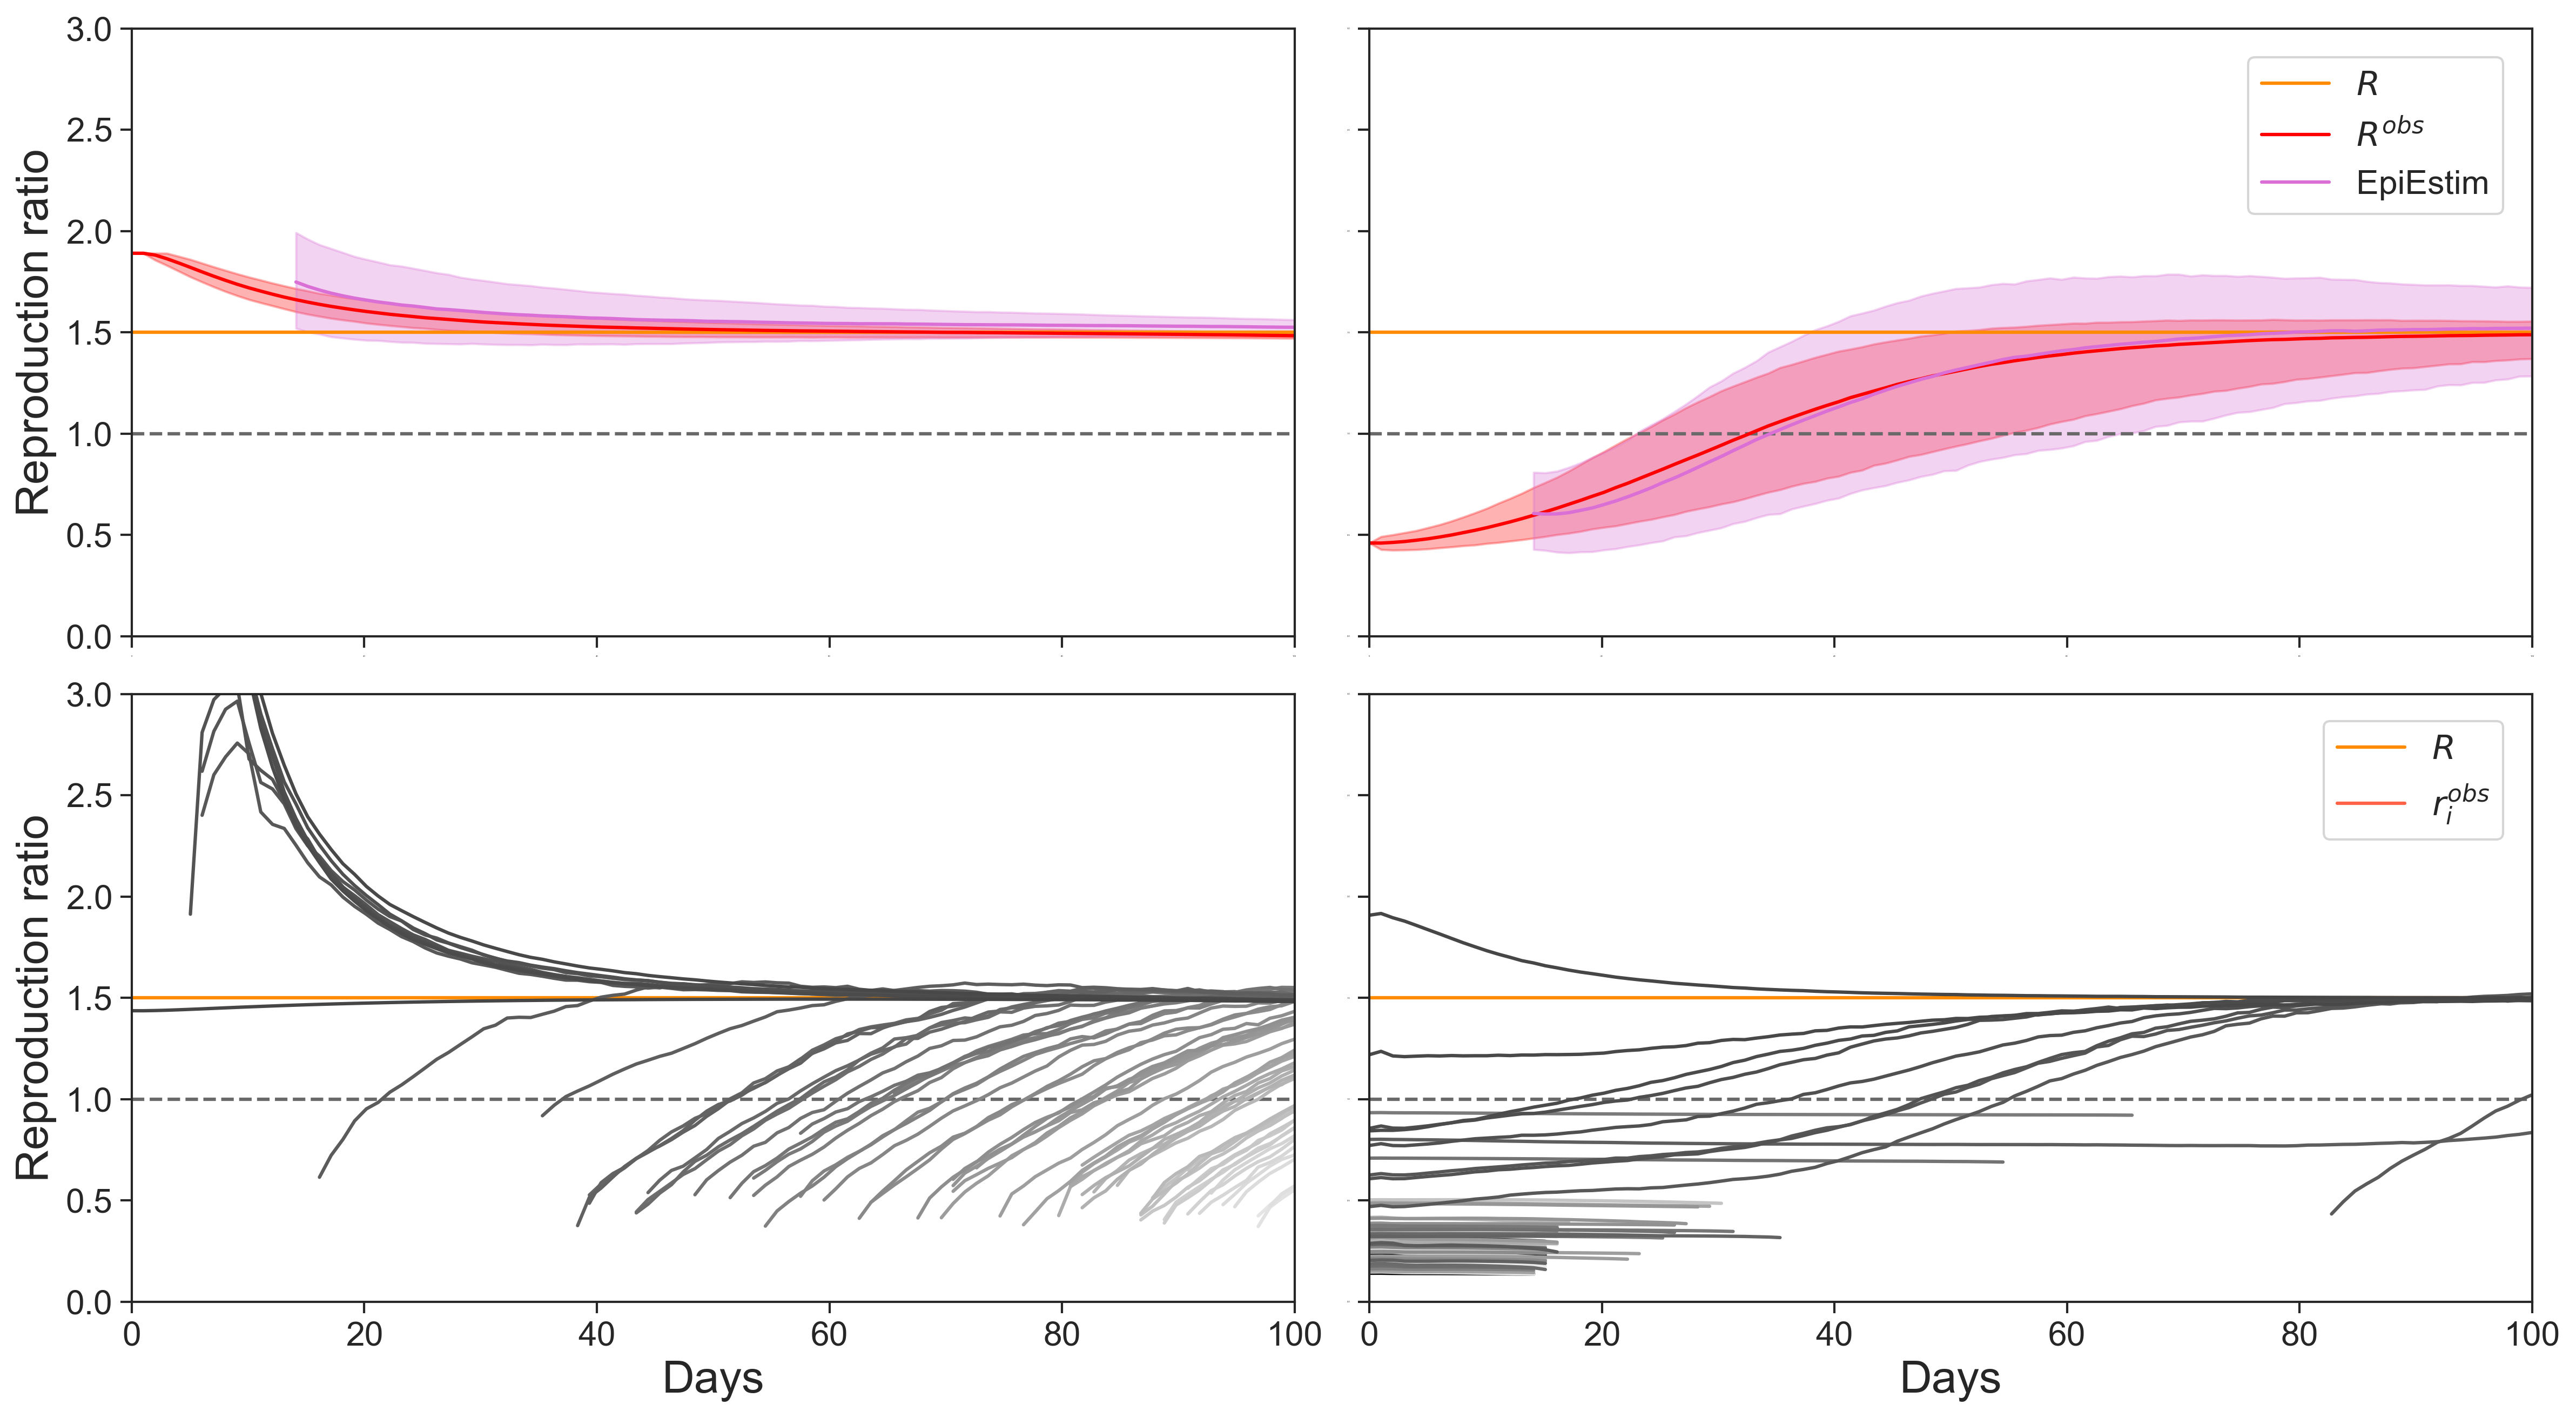

In [30]:
S_panel_plotter_Fig1(S_check,S_epi_check,s_check,max_w_=max_w,save=True,name='Fig1dot0_together_grys_drkrng_July_w')

## Cleaned

In [31]:
np.shape(s_check)

(2, 10000, 111, 94)

In [32]:
def pruner(S):
    S_=S.copy()
    for i in range(len(S_)):
        for run in range(len(S_[0])):
            if (S_[i,run]==0).any():
                S_[i,run]=np.empty(len(S_[i,run]))
                S_[i,run,:]=np.NaN
    return S_

def pruner_i(s):
    s_=s.copy()
    for i in range(len(s_)):
        for run in range(len(s_[0])):
            for patch in range(len(s_[0][0])):
                for t in range(len(s_[0][0][0])):
                    if (s_[i,run,patch,t]==0):
                        s_[i,run,patch,t]=np.NaN
    return s_

In [33]:
S_check_pruned=pruner(S_check)
S_epi_check_pruned=pruner(S_epi_check)
s_check_pruned=pruner_i(s_check)

In [34]:
def S_panel_plotter_Fig1_pruned(S,S_Epi,s,dim1=2,dim2=2,max_w_=max_w,end=[101,101],start=0,save=False,name='a',tit=None):
    
    fig,ax = plt.subplots(dim1,dim2,figsize=(16,9),dpi=300)
    c=['darkorange','tab:blue','dimgrey','r','orchid','coral']
    x=np.linspace(0,len(S[0,0]),len(S[0,0]))
    pref=params['beta']/params['mu']
    w1=pref*np.amax(np.linalg.eig(Q_2021_02_02)[0])
    fig.suptitle(tit,fontsize=20 )
    sh=14
    cp=sns.color_palette('gray_r',len(polygons))#+25)[:-25]
    #cp1=cp[:-25]
    #cp2=cp[-25:]
    #cp=np.concatenate((cp2,cp1))

    for i,a in enumerate (ax.reshape(-1)[:2]): 
        m=pref*np.nanpercentile(S[i],50,axis=0)
        CI=pref*np.array((np.nanpercentile(S[i],2.5,axis=0),np.nanpercentile(S[i],97.5,axis=0)))
        m_Epi=np.nanpercentile(S_Epi[i],50,axis=0)
        CI_Epi=np.array((np.nanpercentile(S_Epi[i],2.5,axis=0),np.nanpercentile(S_Epi[i],97.5,axis=0)))
        mw=pref*np.nanpercentile(max_w_[i],50,axis=0)
        CIw=pref*np.array((np.nanpercentile(max_w_[i],2.5,axis=0),np.nanpercentile(max_w_[i],97.5,axis=0)))
        a.axhline(1,0,1,color=c[2],linestyle='dashed',alpha=1)
        a.plot(x[start:end[i]],mw[start:end[i]],label=r'$R$',color=c[0])
        a.fill_between(x[start:end[i]],CIw[0][start:end[i]],CIw[1][start:end[i]], color=c[0],alpha=.3)
        a.plot(x[start:end[i]],m[start:end[i]],label=r'$R^{obs}$',color=c[3])
        a.fill_between(x[start:end[i]],CI[0][start:end[i]],CI[1][start:end[i]], color=c[3],alpha=.3)
        a.plot(x[start+sh:end[i]],m_Epi[start+(sh-5):end[i]-5],label='EpiEstim',color=c[4])
        a.fill_between(x[start+sh:end[i]],CI_Epi[0][start+(sh-5):end[i]-5],CI_Epi[1][start+(sh-5):end[i]-5], color=c[4],alpha=.3)
        a.tick_params(axis='x', labelsize=0)
        if i==1:
            a.tick_params(axis='y',labelsize=0)
        else:
            a.tick_params(axis='y',labelsize=15)
        a.set_ylim([0,3])
        a.set_xlim([0,100])
        
    handles, labels = a.get_legend_handles_labels()
    fig.legend(handles, labels, ncol=1,bbox_to_anchor=(0.975, 0.95),bbox_transform=fig.transFigure, frameon=True,fontsize=15)#0.975,0.449/0.485/0.262
        
    for i,a in enumerate (ax.reshape(-1)[2:]): 
        m=(pref*np.nanpercentile(s[i],50,axis=0))
        m=np.where(m==0,np.nan,m)
        mw=(pref*np.nanpercentile(max_w_[i],50,axis=0))
        CIw=(pref*np.array((np.nanpercentile(max_w_[i],2.5,axis=0),np.nanpercentile(max_w_[i],97.5,axis=0))))
        order=(np.argsort(max_v))
        a.set_prop_cycle('color',cp)
        a.axhline(1,0,1,color='dimgrey',linestyle='dashed',alpha=1)
        a.plot(x[start:end[i]],mw[start:end[i]],label=r'$R$',color=c[0],alpha=1)
        a.axhline(4,0,1,color='tomato',alpha=1,label=r'$r^{obs}_i$')
        mT=m.T
        for p in order:
            a.plot(x[start:end[i]],mT[p][start:end[i]],alpha=1)
        print(len(m[start:end[i],0]))
        a.tick_params(axis='x',labelsize=15)
        if i==1:
            a.tick_params(axis='y',labelsize=0)
        else:
            a.tick_params(axis='y',labelsize=15)
        a.set_ylim([0,3])
        a.set_xlim([0,100])
        a.set_xlabel('Days',fontsize=20)
        
    ax[0][0].set_ylabel('Reproduction ratio',fontsize=20)
    ax[1][0].set_ylabel('Reproduction ratio',fontsize=20)
    handles, labels = a.get_legend_handles_labels()
    fig.legend(handles, labels, ncol=1,bbox_to_anchor=(0.975, 0.495),bbox_transform=fig.transFigure, frameon=True,fontsize=15)
    fig.tight_layout()
    if (save==True):
        fig.savefig('C:/Users/piero/Documents/PHD/eugenio/PLOTS/paperdot0/Figure2dot1_new_.svg',bbox_inches='tight')
        fig.savefig('C:/Users/piero/Documents/PHD/eugenio/PLOTS/paperdot0/Figure2dot1_new_.pdf',bbox_inches='tight')
        fig.savefig('C:/Users/piero/Documents/PHD/eugenio/PLOTS/paperdot0/Figure2dot1_new_',bbox_inches='tight')

c:\Users\piero\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
c:\Users\piero\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
c:\Users\piero\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


101


c:\Users\piero\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


101


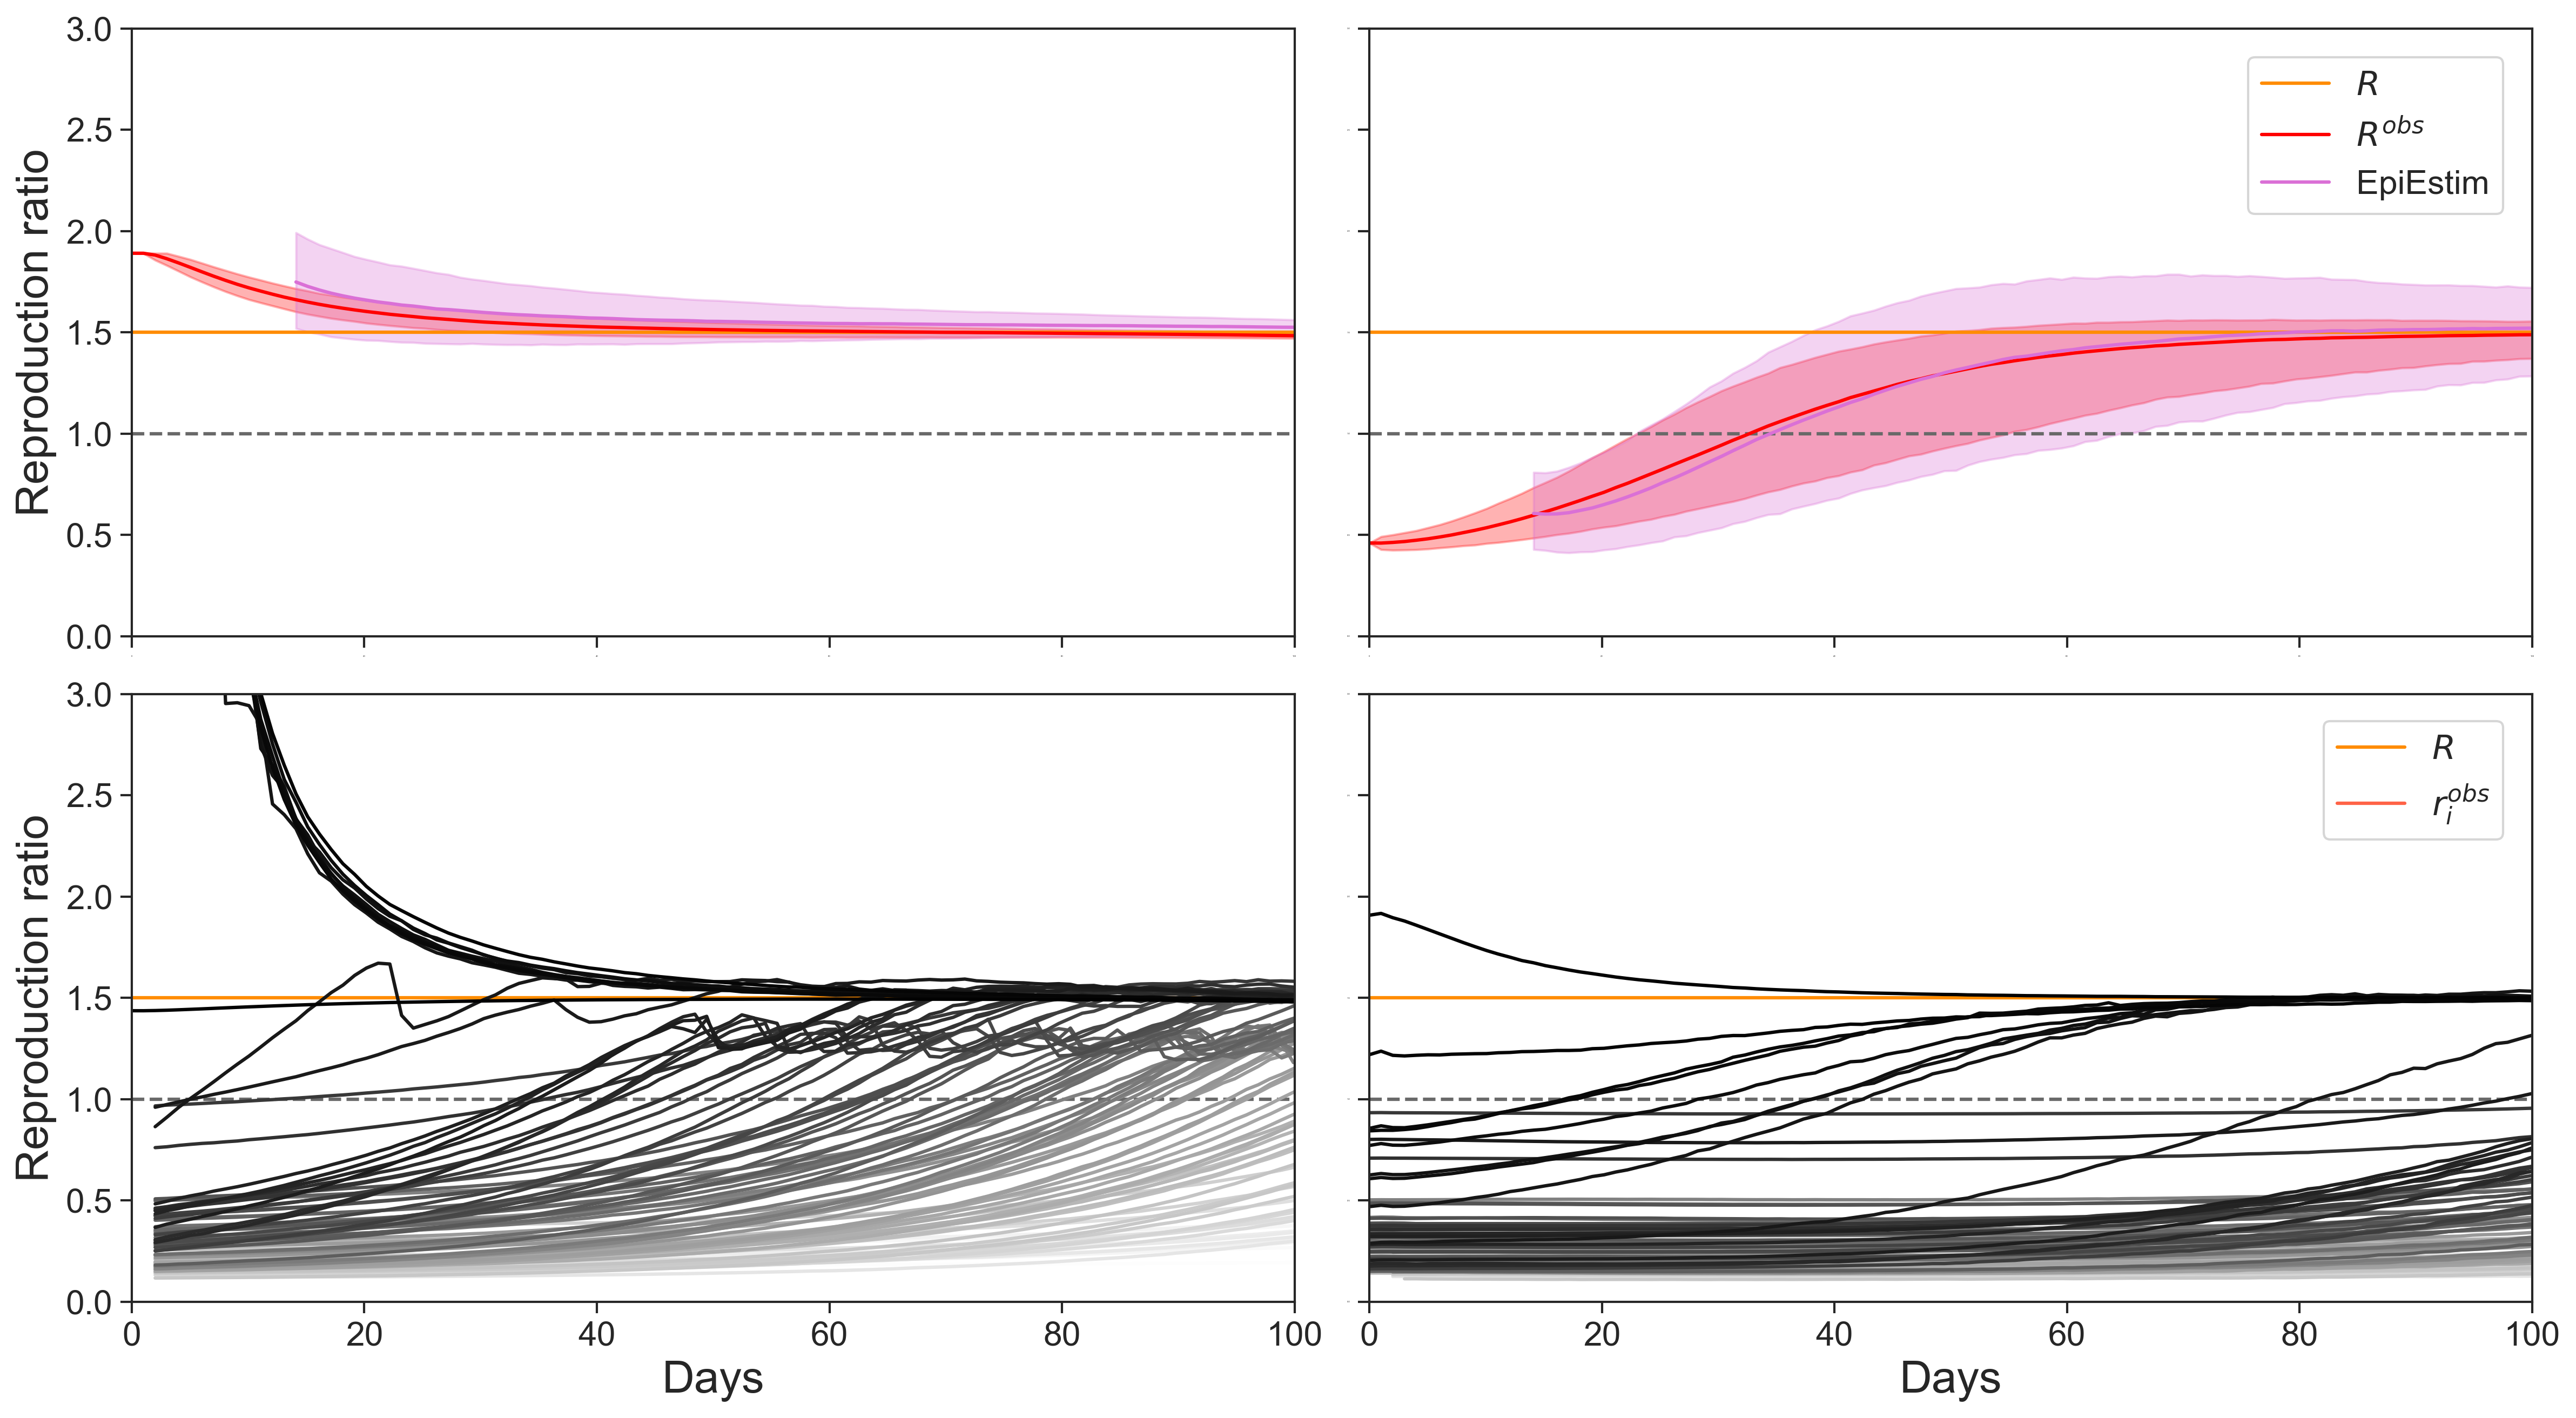

In [35]:
S_panel_plotter_Fig1_pruned(S_check_pruned,S_epi_check_pruned,s_check_pruned,max_w_=max_w,save=True,name='Fig1dot0_together_grys_drkrng_July_w')

## Horizontal

In [52]:
def S_vcorr_Fig4(S,S_proj,S_Epi,S_Epi_proj,dim1=1,dim2=2,proj=False,max_w_=max_w,end=[101,101],start=0,save=False,name='a',tit=None):
    
    fig,ax = plt.subplots(dim1,dim2,figsize=(16,5),dpi=300)
    c=['darkorange','tab:blue','dimgrey','r','orchid','coral']
    x=np.linspace(0,len(S[0,0]),len(S[0,0]))
    pref=params['beta']/params['mu']
    w1=pref*np.amax(np.linalg.eig(Q_2021_02_02)[0])
    fig.suptitle(tit,fontsize=20 )
    sh=14

    for i,a in enumerate (ax.reshape(-1)): 
        m=pref*np.percentile(S[i],50,axis=0)
        CI=pref*np.array((np.percentile(S[i],2.5,axis=0),np.percentile(S[i],97.5,axis=0)))
        m_proj=pref*np.percentile(S_proj[i],50,axis=0)
        CI_proj=pref*np.array((np.percentile(S_proj[i],2.5,axis=0),np.percentile(S_proj[i],97.5,axis=0)))
        m_Epi=np.percentile(S_Epi[i],50,axis=0)
        CI_Epi=np.array((np.percentile(S_Epi[i],2.5,axis=0),np.percentile(S_Epi[i],97.5,axis=0)))
        m_Epi_proj=np.percentile(S_Epi_proj[i],50,axis=0)
        CI_Epi_proj=np.array((np.percentile(S_Epi_proj[i],2.5,axis=0),np.percentile(S_Epi_proj[i],97.5,axis=0)))
        mw=pref*np.percentile(max_w_[i],50,axis=0)
        CIw=pref*np.array((np.percentile(max_w_[i],2.5,axis=0),np.percentile(max_w_[i],97.5,axis=0)))
        a.axhline(1,0,1,color=c[2],linestyle='dashed',alpha=1)
        a.plot(x[start:end[i]],mw[start:end[i]],label=r'$R$',color=c[0])
        a.fill_between(x[start:end[i]],CIw[0][start:end[i]],CIw[1][start:end[i]], color=c[0],alpha=.3)
        a.plot(x[start:end[i]],m[start:end[i]],label=r'$R^{obs}$',color=c[3])
        a.fill_between(x[start:end[i]],CI[0][start:end[i]],CI[1][start:end[i]], color=c[3],alpha=.3)
        a.plot(x[start+sh:end[i]],m_Epi[start+(sh-5):end[i]-5],label='EpiEstim',color=c[4])
        a.fill_between(x[start+sh:end[i]],CI_Epi[0][start+(sh-5):end[i]-5],CI_Epi[1][start+(sh-5):end[i]-5], color=c[4],alpha=.3)
        if(proj==True):
            a.plot(x[start:end[i]],m_proj[start:end[i]],label=r'$R^{corr}$',color='tab:blue')
            a.fill_between(x[start:end[i]],CI_proj[0][start:end[i]],CI_proj[1][start:end[i]], color='tab:blue',alpha=.3)
            a.plot(x[start+sh:end[i]],m_Epi_proj[start+(sh-5):end[i]-5],label=r'EpiEstim$^{corr}$',color='lightsteelblue')#cornflowerblue
            a.fill_between(x[start+sh:end[i]],CI_Epi_proj[0][start+(sh-5):end[i]-5],CI_Epi_proj[1][start+(sh-5):end[i]-5], color='lightsteelblue',alpha=.3)
        a.tick_params(axis='x',labelsize=15)
        if i==0:
            a.tick_params(axis='y', labelsize=15)
            a.set_ylabel('Reproduction ratio',fontsize=20)
        else:
            a.tick_params(axis='y', labelsize=0)
        a.set_ylim([0,3])
        a.set_xlim([0,100])
        a.set_xlabel('Days',fontsize=20)
    handles, labels = a.get_legend_handles_labels()
    fig.legend(handles, labels, ncol=2,bbox_to_anchor=(0.975, 0.915),bbox_transform=fig.transFigure, frameon=True,fontsize=15)#0.975,0.449/0.485/0.262
    fig.tight_layout()
    if (save==True):
        fig.savefig('C:/Users/piero/Documents/PHD/eugenio/PLOTS/paperdot0/Figure3dot0_new_.svg',bbox_inches='tight')
        fig.savefig('C:/Users/piero/Documents/PHD/eugenio/PLOTS/paperdot0/Figure3dot0_new_.pdf',bbox_inches='tight')
        fig.savefig('C:/Users/piero/Documents/PHD/eugenio/PLOTS/paperdot0/Figure3dot0_new_',bbox_inches='tight')

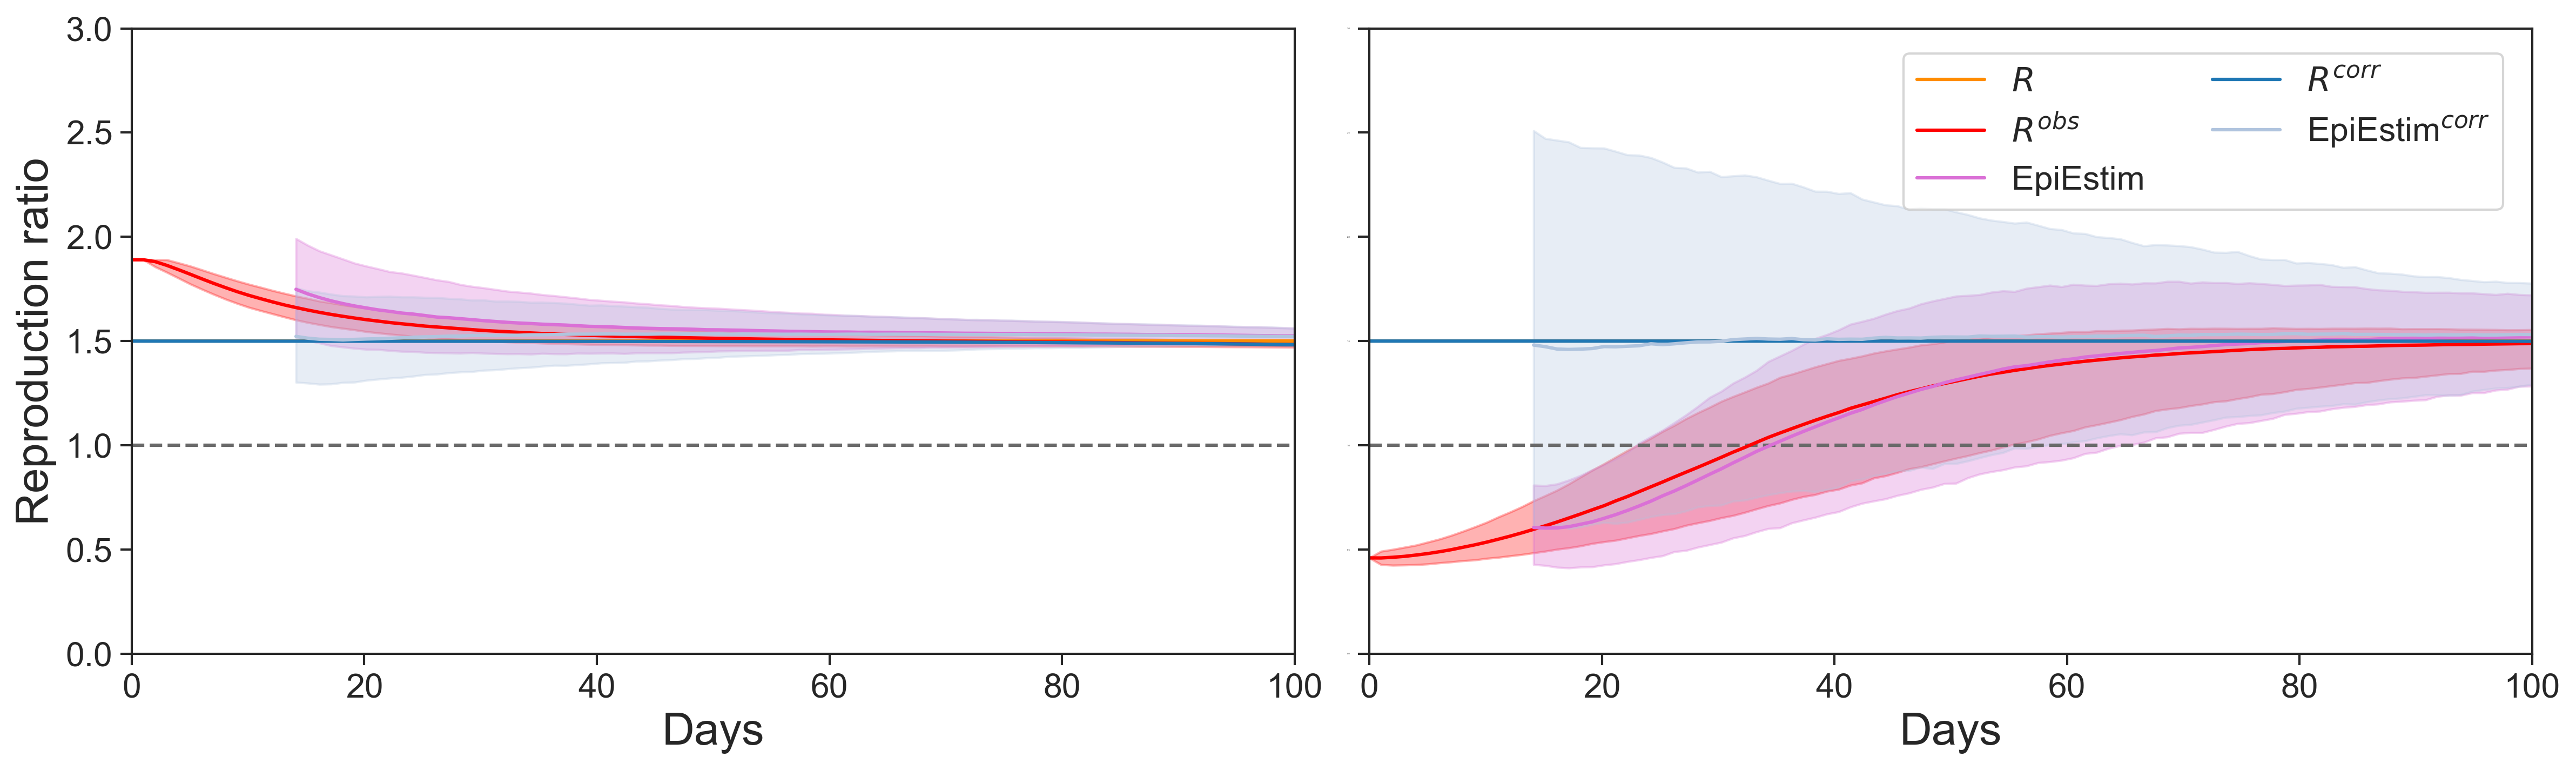

In [53]:
S_vcorr_Fig4(S_check,S_zproj_check,S_epi_check,S_epi_check_zproj,max_w_=max_w,proj=True,save=True,name='Fig4_hor_drkrng_July_w')

## Is pointwise median a qualitative match for simulations? 

In [45]:
def S_vcorr_pm(S,S_proj,S_Epi,S_Epi_proj,dim1=2,dim2=2,proj=False,max_w_=max_w,end=[101,101],start=0,save=False,name='a',tit=None):
    
    fig,ax = plt.subplots(dim1,dim2,figsize=(16,10),dpi=300)
    c=['darkorange','tab:blue','dimgrey','r','orchid','coral']
    x=np.linspace(0,len(S[0,0]),len(S[0,0]))
    pref=params['beta']/params['mu']
    w1=pref*np.amax(np.linalg.eig(Q_2021_02_02)[0])
    fig.suptitle(tit,fontsize=20)
    sh=14

    runs=[0,111,222,333,444]

    for j,a in enumerate (ax.reshape(-1)): 

        i=1

        m=pref*np.percentile(S[i],50,axis=0)
        CI=pref*np.array((np.percentile(S[i],2.5,axis=0),np.percentile(S[i],97.5,axis=0)))
        m_=[pref*S[i,runs[run]] for run in range(len(runs))]
        
        m_proj=pref*np.percentile(S_proj[i],50,axis=0)
        CI_proj=pref*np.array((np.percentile(S_proj[i],2.5,axis=0),np.percentile(S_proj[i],97.5,axis=0)))
        m_proj_=[pref*S_proj[i,runs[run]] for run in range(len(runs))]

        m_Epi=np.percentile(S_Epi[i],50,axis=0)
        CI_Epi=np.array((np.percentile(S_Epi[i],2.5,axis=0),np.percentile(S_Epi[i],97.5,axis=0)))
        m_Epi_=[S_Epi[i,runs[run]] for run in range(len(runs))]

        m_Epi_proj=np.percentile(S_Epi_proj[i],50,axis=0)
        CI_Epi_proj=np.array((np.percentile(S_Epi_proj[i],2.5,axis=0),np.percentile(S_Epi_proj[i],97.5,axis=0)))
        m_Epi_proj_=[S_Epi_proj[i,runs[run]] for run in range(len(runs))]

        mw=pref*np.percentile(max_w_[i],50,axis=0)
        CIw=pref*np.array((np.percentile(max_w_[i],2.5,axis=0),np.percentile(max_w_[i],97.5,axis=0)))
        a.axhline(1,0,1,color=c[2],linestyle='dashed',alpha=1)#,label=r'$\mathcal{R}_0=r[Q_0]$')
        a.plot(x[start:end[i]],mw[start:end[i]],label=r'$R$',color=c[0],alpha=.5)
        #a.fill_between(x[start:end[i]],CIw[0][start:end[i]],CIw[1][start:end[i]], color=c[0],alpha=.3)

        if (j==0):
            a.plot(x[start:end[i]],m[start:end[i]],label=r'$R^{obs}$',color=c[3])
            a.fill_between(x[start:end[i]],CI[0][start:end[i]],CI[1][start:end[i]], color=c[3],alpha=.1)
            for run in range(len(runs)-1):
                a.plot(x[start:end[i]],m_[run][start:end[i]],color=c[3],alpha=.3)
            a.plot(x[start:end[i]],m_[-1][start:end[i]],label=r'$R^{obs}$ single runs',color=c[3],alpha=.3)

        if(j==1):
            a.plot(x[start:end[i]],m_proj[start:end[i]],label=r'$R^{corr}$',color='tab:blue')
            a.fill_between(x[start:end[i]],CI_proj[0][start:end[i]],CI_proj[1][start:end[i]], color='tab:blue',alpha=.1)
            for run in range(len(runs)-1):
                a.plot(x[start:end[i]],m_proj_[run][start:end[i]],color='tab:blue',alpha=.3)
            a.plot(x[start:end[i]],m_proj_[-1][start:end[i]],label=r'$R^{corr}$ single runs',color='tab:blue',alpha=.3) 

        if (j==2):
            a.plot(x[start+sh:end[i]],m_Epi[start+(sh-5):end[i]-5],label='EpiEstim',color=c[4])
            a.fill_between(x[start+sh:end[i]],CI_Epi[0][start+(sh-5):end[i]-5],CI_Epi[1][start+(sh-5):end[i]-5], color=c[4],alpha=.1)
            for run in range(len(runs)-1):
                a.plot(x[start+sh:end[i]],m_Epi_[run][start+(sh-5):end[i]-5],color=c[4],alpha=.3)
            a.plot(x[start+sh:end[i]],m_Epi_[-1][start+(sh-5):end[i]-5],label=f'EpiEstim single runs',color=c[4],alpha=.3)

        if(j==3):
            a.plot(x[start+sh:end[i]],m_Epi_proj[start+(sh-5):end[i]-5],label=r'EpiEstim$^{corr}$',color='steelblue')#cornflowerblue
            a.fill_between(x[start+sh:end[i]],CI_Epi_proj[0][start+(sh-5):end[i]-5],CI_Epi_proj[1][start+(sh-5):end[i]-5], color='lightsteelblue',alpha=.2)
            for run in range(len(runs)-1):
                a.plot(x[start+sh:end[i]],m_Epi_proj_[run][start+(sh-5):end[i]-5],color='lightsteelblue',alpha=.5)
            a.plot(x[start+sh:end[i]],m_Epi_proj_[-1][start+(sh-5):end[i]-5],label=r'EpiEstim$^{corr}$ single runs',color='lightsteelblue',alpha=.5)

        a.tick_params(axis='x',labelsize=15)
        a.tick_params(axis='y',labelsize=15)

        a.set_ylim([0,3])
        a.set_xlim([0,100])
        a.legend(fontsize=15,frameon=True)

    ax[0][0].set_ylabel('Reproduction ratio',fontsize=20)
    ax[1][0].set_ylabel('Reproduction ratio',fontsize=20)
    ax[0][1].tick_params(axis='y', labelsize=0)
    ax[1][1].tick_params(axis='y', labelsize=0)
    ax[1][0].set_xlabel('Days',fontsize=20)
    ax[1][1].set_xlabel('Days',fontsize=20)
    ax[0][0].tick_params(axis='x',labelsize=0)
    ax[0][1].tick_params(axis='x',labelsize=0)

    fig.tight_layout()
    if (save==True):
        fig.savefig('C:/Users/piero/Documents/PHD/eugenio/PLOTS/paperdot0/SIandmore/FigureSupPM_new_.svg',bbox_inches='tight')
        fig.savefig('C:/Users/piero/Documents/PHD/eugenio/PLOTS/paperdot0/SIandmore/FigureSupPM_new_.pdf',bbox_inches='tight')
        fig.savefig('C:/Users/piero/Documents/PHD/eugenio/PLOTS/paperdot0/SIandmore/FigureSupPM_new_',bbox_inches='tight')

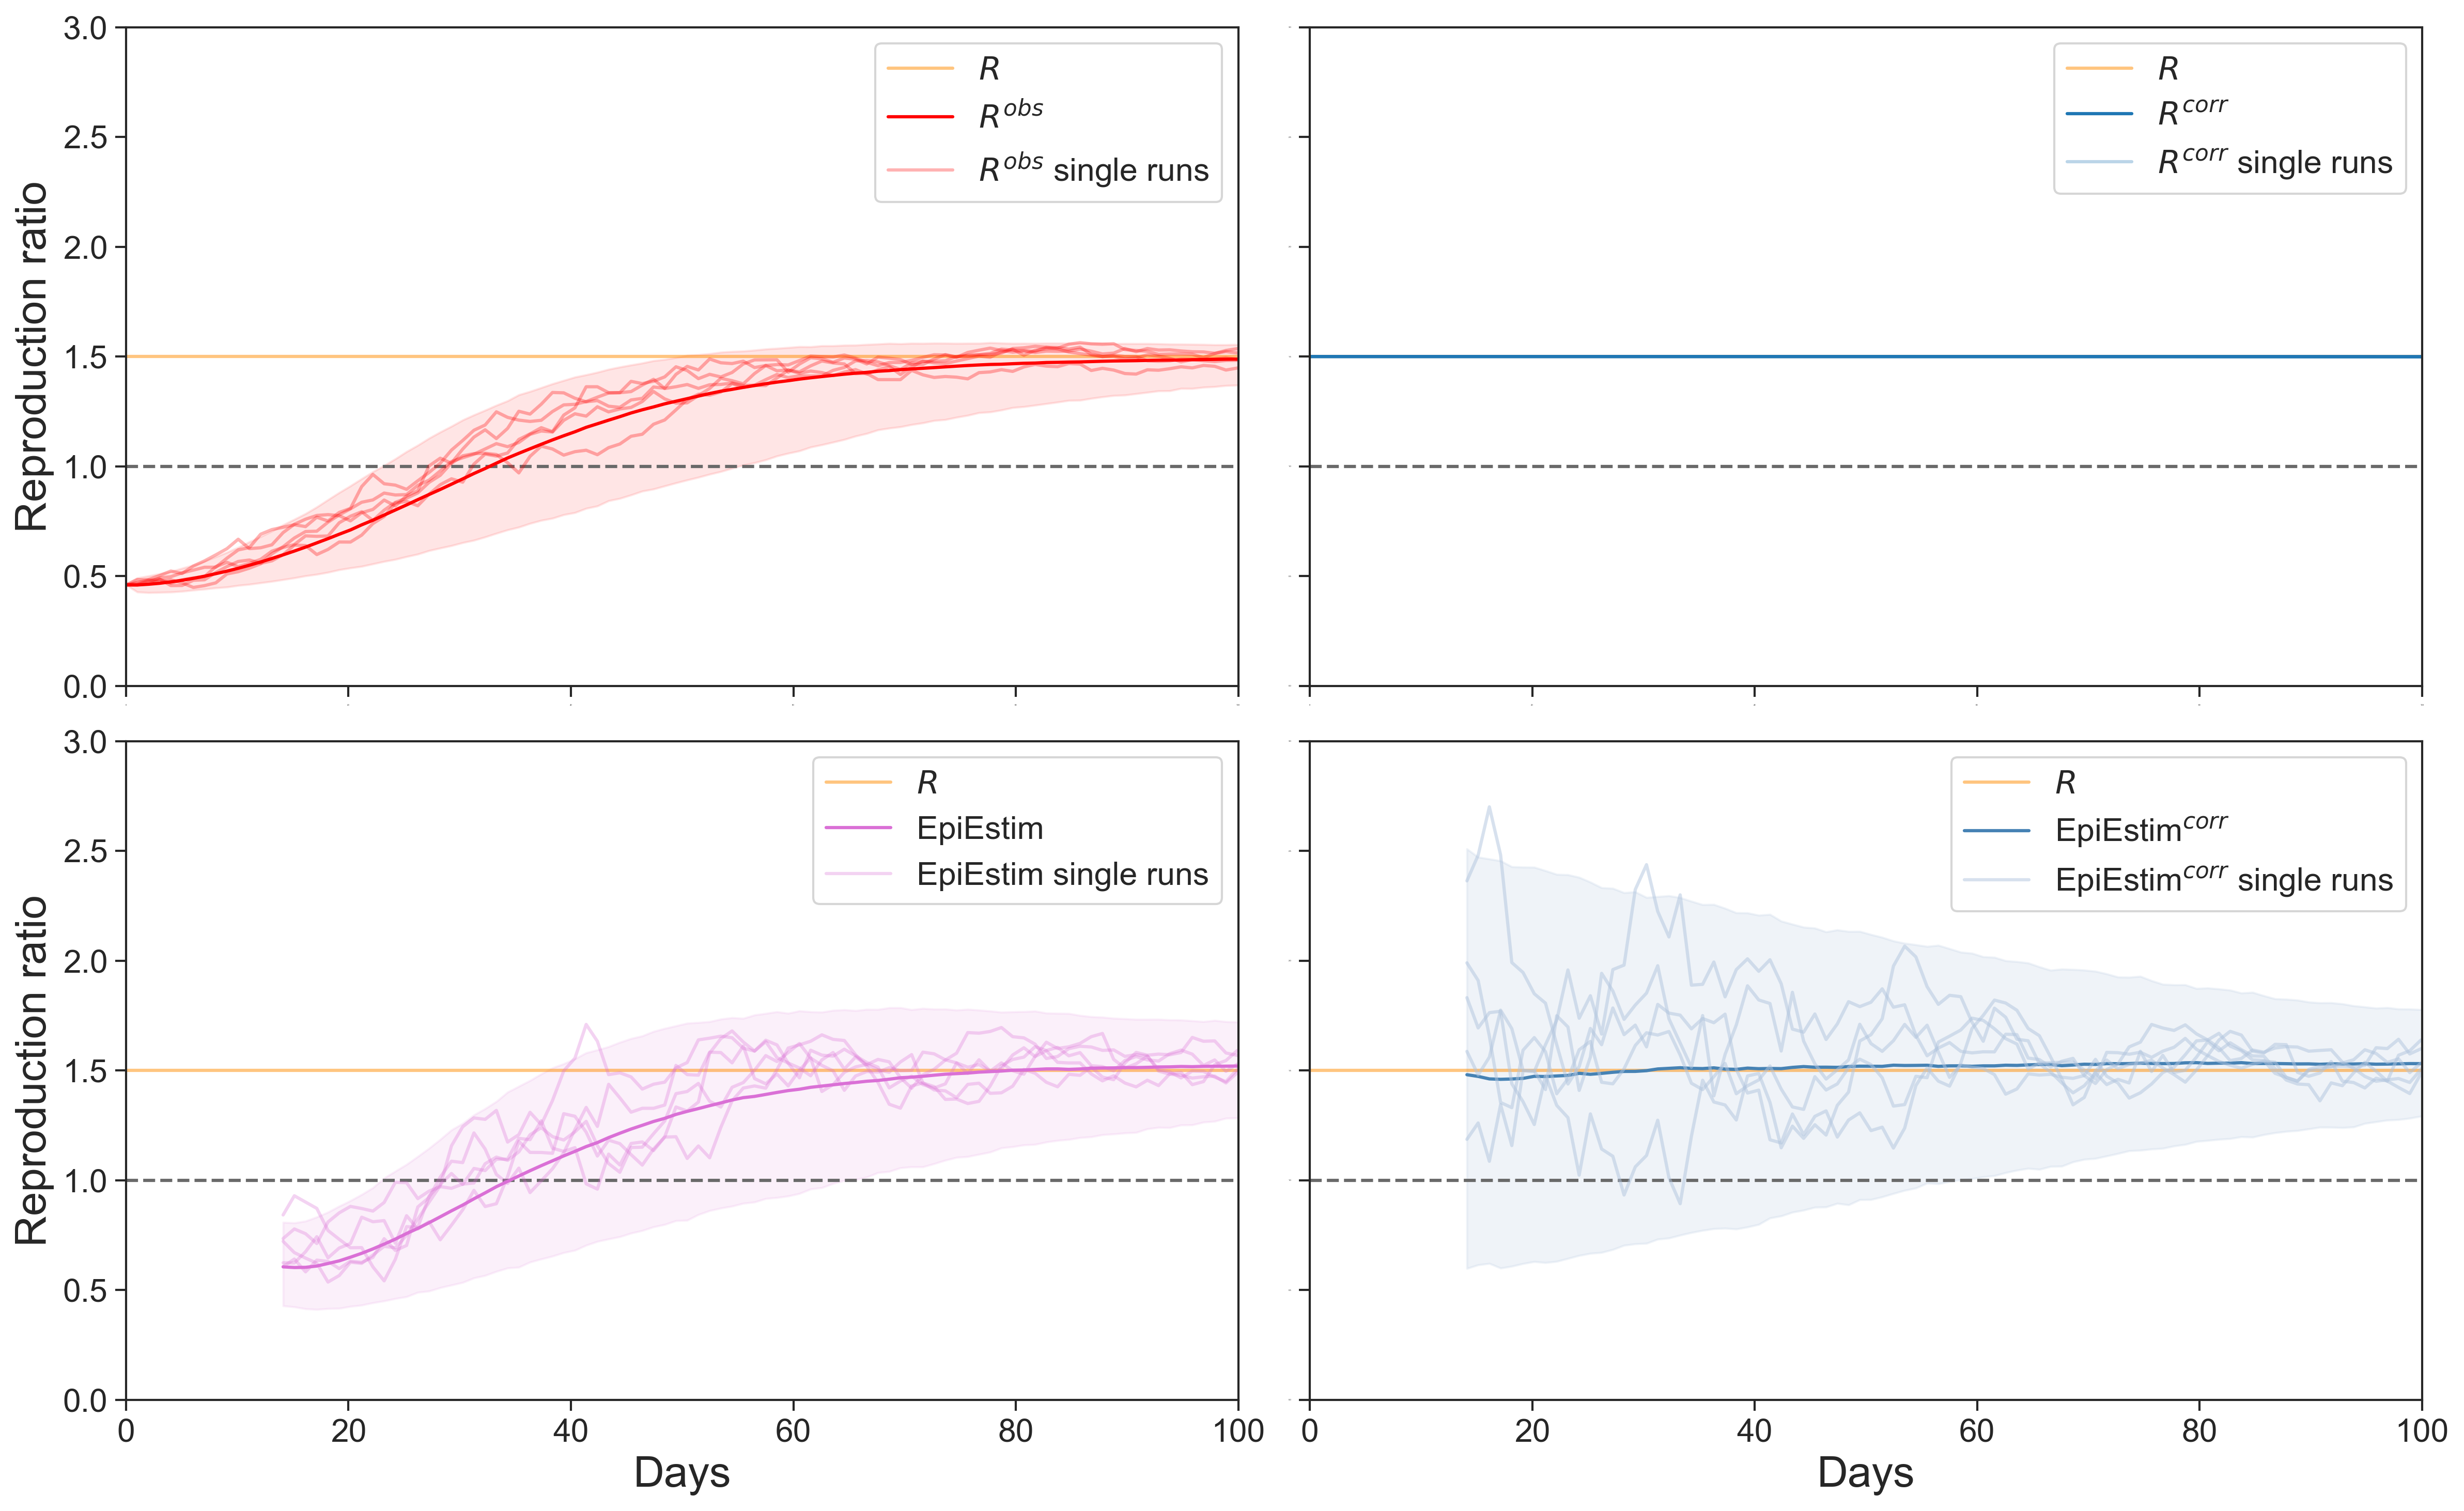

In [46]:
S_vcorr_pm(S_check,S_zproj_check,S_epi_check,S_epi_check_zproj,max_w_=max_w,proj=False,save=True,name='Fig4_hor_drkrng_July_w')

In [31]:
print( np.shape(S_check), np.shape(S_zproj_check) , np.shape(S_epi_check) , np.shape(S_epi_check_zproj) )

(2, 1000, 181) (2, 1000, 181) (2, 1000, 174) (2, 1000, 174)


In [32]:
pref=params['beta']*(1-params['p_sc']+params['beta_I']*params['p_sc'])/params['mu']
print(pref*S_zproj_check[0][111][:10])

[1.49965088 1.49925987 1.4992026  1.49914668 1.49908268 1.49902101
 1.49896966 1.4989188  1.49885526 1.49879183]


## $s_i$

In [47]:
def si_pm(S,s,selected_i,dim1=3,dim2=2,max_w_=max_w,end=[101,101],start=0,save=False,name='a',tit=None):
    
    fig,ax = plt.subplots(dim1,dim2,figsize=(16,15))#,dpi=300)
    c=['darkorange','tab:blue','dimgrey','r','orchid','coral']
    x=np.linspace(0,len(S[0,0]),len(S[0,0]))
    pref=params['beta']/params['mu']
    w1=pref*np.amax(np.linalg.eig(Q_2021_02_02)[0])
    fig.suptitle(tit,fontsize=20 )
    sh=14
    cp=sns.color_palette('gray_r',len(polygons))
    cp1=cp[:-25]
    cp2=cp[-25:]
    cp=np.concatenate((cp2,cp1))

    runs=[0,111,222,333,444]
        
    for j,a in enumerate (ax.reshape(-1)):

        i=1
        row=j

        m=(pref*np.percentile(s[i,:,:,selected_i[j]],50,axis=0))
        m=np.where(m==0,np.nan,m)
        CI=( pref*np.percentile(s[i,:,:,selected_i[j]],2.5,axis=0) , pref*np.percentile(s[i,:,:,selected_i[j]],97.5,axis=0) )
        mw=(pref*np.percentile(max_w_[i],50,axis=0))
        CIw=(pref*np.array((np.percentile(max_w_[i],2.5,axis=0),np.percentile(max_w_[i],97.5,axis=0))))

        a.axhline(1,0,1,color='dimgrey',linestyle='dashed',alpha=1)
        a.plot(x[start:end[i]],mw[start:end[i]],label=r'$R$',color=c[0],alpha=.5)

        a.plot(x[start:end[i]],m[start:end[i]],label=str(polygons.iloc[selected_i[j]]),color='k')
        a.fill_between(x[start:end[i]],CI[0][start:end[i]],CI[1][start:end[i]],color='k',alpha=.2)

        for run in runs[:-1]:
            m_=pref*s[i,run,:,selected_i[j]]
            m_=np.where(m_==0,np.nan,m_)
            a.plot(x[start:end[i]],m_[start:end[i]],alpha=.5,color='k')
        m_=pref*s[i,-1,:,selected_i[j]]
        m_=np.where(m_==0,np.nan,m_)
        a.plot(x[start:end[i]],m_[start:end[i]],alpha=.5,color='k',label=str(polygons.iloc[selected_i[j]])+str(', single runs'))
        
        a.tick_params(axis='x',labelsize=15)
        a.tick_params(axis='y',labelsize=15)
        a.set_ylim([0,3])
        a.set_xlim([0,100])
        a.legend(fontsize=15,frameon=True)

    ax[0][0].set_ylabel('Reproduction ratio',fontsize=20)
    ax[1][0].set_ylabel('Reproduction ratio',fontsize=20)
    ax[2][0].set_ylabel('Reproduction ratio',fontsize=20)
    ax[0][1].tick_params(axis='y', labelsize=0)
    ax[1][1].tick_params(axis='y', labelsize=0)
    ax[2][1].tick_params(axis='y', labelsize=0)
    ax[2][0].set_xlabel('Days',fontsize=20)
    ax[2][1].set_xlabel('Days',fontsize=20)
    ax[0][0].tick_params(axis='x',labelsize=0)
    ax[0][1].tick_params(axis='x',labelsize=0) 
    ax[1][0].tick_params(axis='x',labelsize=0)
    ax[1][1].tick_params(axis='x',labelsize=0)    
    fig.tight_layout()
    if (save==True):
        fig.savefig('C:/Users/piero/Documents/PHD/eugenio/PLOTS/paperdot0/SIandmore/FigureSupPMsi_new_.svg',bbox_inches='tight')
        fig.savefig('C:/Users/piero/Documents/PHD/eugenio/PLOTS/paperdot0/SIandmore/FigureSupPMsi_new_.pdf',bbox_inches='tight')
        fig.savefig('C:/Users/piero/Documents/PHD/eugenio/PLOTS/paperdot0/SIandmore/FigureSupPMsi_new_',bbox_inches='tight')

In [48]:
w,vl,vr=scipy.linalg.eig(Q_2021_02_02,left=True)
v=[]
z=[]
for u,wu in enumerate (w):
    v.append(vr[:,u]/np.sum(vr[:,u]))
    z.append(vl[:,u]/np.sum(vl[:,u]))
v=np.array(v)
z=np.array(z)
max_v=v[w.argmax()] 
max_z=z[w.argmax()]
projectors=np.array([[[v[alpha][j]*z[alpha][k] for k in range(N)] for j in range(N)] for alpha in range(N)])

#-----------------------------------------------------------------

selected_i=np.flip(np.argsort(max_v)[-6:])
for i in range (6):
    print(polygons.iloc[np.argsort(max_v)[-(i+1)]],np.sort(max_v)[-(i+1)])

Paris 0.6187106968503224
Hauts-de-Seine 0.10709834476249662
Seine-Saint-Denis 0.09158953188934467
Val-de-Marne 0.06054107246019619
Val-d'Oise 0.035879144646901284
Essonne 0.023547913356975984


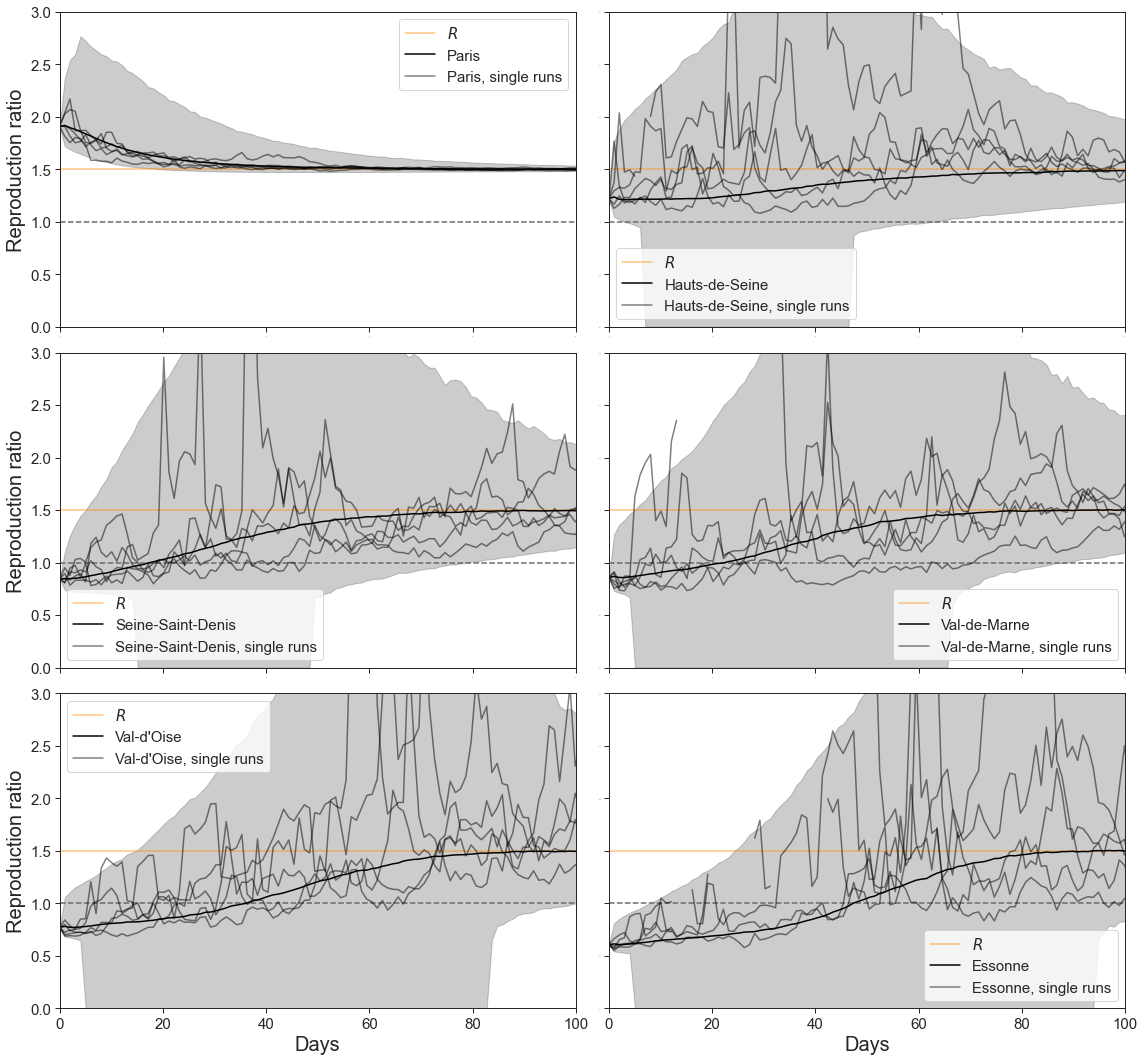

In [49]:
si_pm(S_check,s_check,selected_i,max_w_=max_w,save=True,name='FigureSupPMsidot2.pdf')

In [50]:
def si_pm_clean(S,s,selected_i,dim1=3,dim2=2,max_w_=max_w,end=[150,150],start=0,save=False,name='a',tit=None):
    
    fig,ax = plt.subplots(dim1,dim2,figsize=(16,15))#,dpi=300)
    c=['darkorange','tab:blue','dimgrey','r','orchid','coral']
    x=np.linspace(0,len(S[0,0]),len(S[0,0]))
    pref=params['beta']/params['mu']
    w1=pref*np.amax(np.linalg.eig(Q_2021_02_02)[0])
    fig.suptitle(tit,fontsize=20 )
    sh=14
    cp=sns.color_palette('gray_r',len(polygons))
    cp1=cp[:-25]
    cp2=cp[-25:]
    cp=np.concatenate((cp2,cp1))

    runs=[0,111,222,333,444]
        
    for j,a in enumerate (ax.reshape(-1)):

        i=1
        row=j

        m=(pref*np.nanpercentile(s[i,:,:,selected_i[j]],50,axis=0))
        m=np.where(m==0,np.nan,m)
        CI=( pref*np.nanpercentile(s[i,:,:,selected_i[j]],2.5,axis=0) , pref*np.nanpercentile(s[i,:,:,selected_i[j]],97.5,axis=0) )
        mw=(pref*np.nanpercentile(max_w_[i],50,axis=0))
        CIw=(pref*np.array((np.nanpercentile(max_w_[i],2.5,axis=0),np.nanpercentile(max_w_[i],97.5,axis=0))))

        a.axhline(1,0,1,color='dimgrey',linestyle='dashed',alpha=1)
        a.plot(x[start:end[i]],mw[start:end[i]],label=r'$R$',color=c[0],alpha=.5)

        a.plot(x[start:end[i]],m[start:end[i]],label=str(polygons.iloc[selected_i[j]]),color='k')
        a.fill_between(x[start:end[i]],CI[0][start:end[i]],CI[1][start:end[i]],color='k',alpha=.2)

        for run in runs[:-1]:
            m_=pref*s[i,run,:,selected_i[j]]
            m_=np.where(m_==0,np.nan,m_)
            a.plot(x[start:end[i]],m_[start:end[i]],alpha=.5,color='k')
        m_=pref*s[i,-1,:,selected_i[j]]
        m_=np.where(m_==0,np.nan,m_)
        a.plot(x[start:end[i]],m_[start:end[i]],alpha=.5,color='k',label=str(polygons.iloc[selected_i[j]])+str(', single runs'))
        
        a.tick_params(axis='x',labelsize=15)
        a.tick_params(axis='y',labelsize=15)
        a.set_ylim([0,3])
        a.set_xlim([0,100])
        a.legend(fontsize=15,frameon=True)

    ax[0][0].set_ylabel('Reproduction ratio',fontsize=20)
    ax[1][0].set_ylabel('Reproduction ratio',fontsize=20)
    ax[2][0].set_ylabel('Reproduction ratio',fontsize=20)
    ax[0][1].tick_params(axis='y', labelsize=0)
    ax[1][1].tick_params(axis='y', labelsize=0)
    ax[2][1].tick_params(axis='y', labelsize=0)
    ax[2][0].set_xlabel('Days',fontsize=20)
    ax[2][1].set_xlabel('Days',fontsize=20)
    ax[0][0].tick_params(axis='x',labelsize=0)
    ax[0][1].tick_params(axis='x',labelsize=0) 
    ax[1][0].tick_params(axis='x',labelsize=0)
    ax[1][1].tick_params(axis='x',labelsize=0)    
    fig.tight_layout()
    if (save==True):
        fig.savefig('C:/Users/piero/Documents/PHD/eugenio/PLOTS/paperdot0/SIandmore/FigureSupPMsi_clean_new_.svg',bbox_inches='tight')
        fig.savefig('C:/Users/piero/Documents/PHD/eugenio/PLOTS/paperdot0/SIandmore/FigureSupPMsi_clean_new_.pdf',bbox_inches='tight')
        fig.savefig('C:/Users/piero/Documents/PHD/eugenio/PLOTS/paperdot0/SIandmore/FigureSupPMsi_clean_new_',bbox_inches='tight')

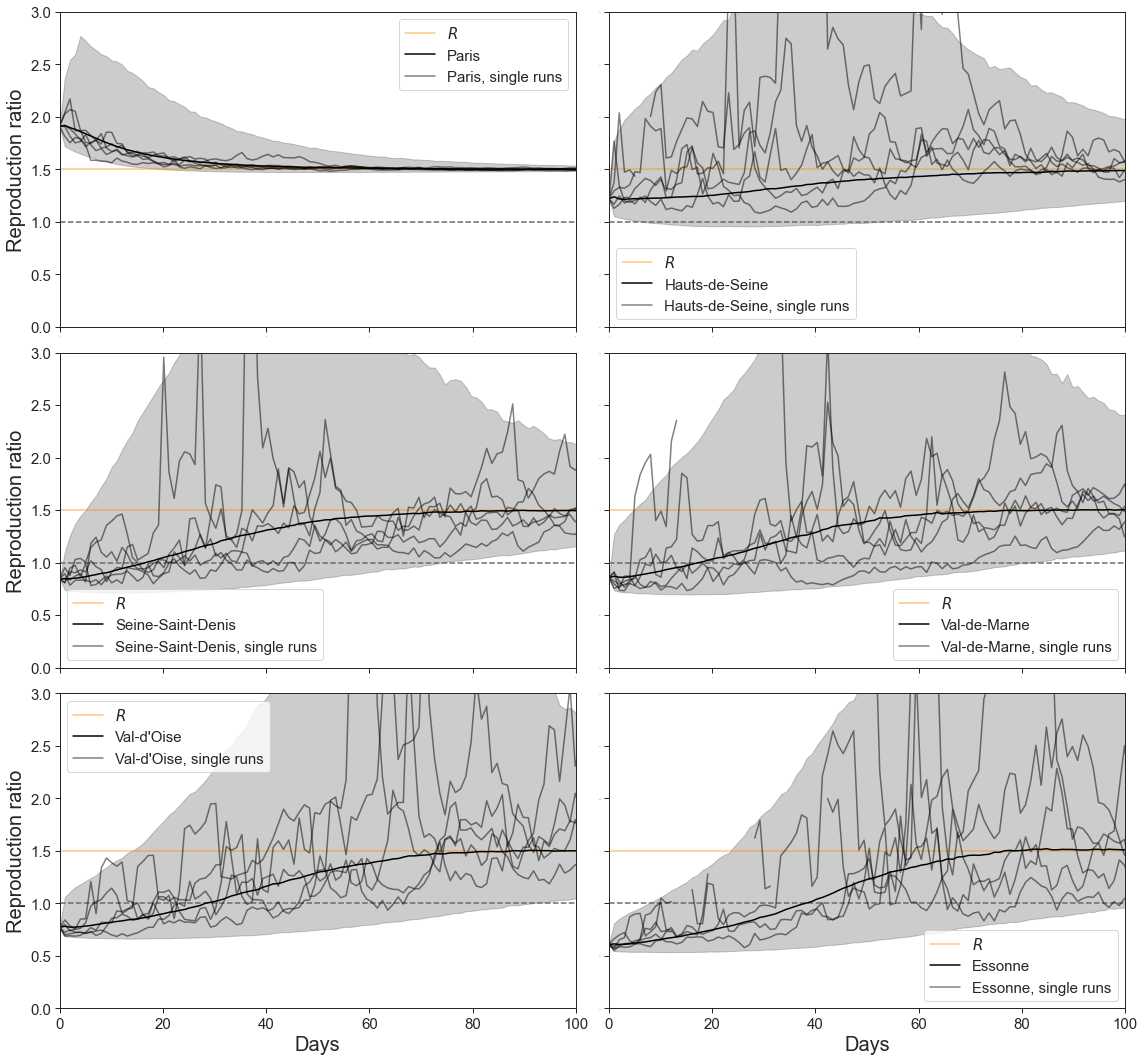

In [51]:
si_pm_clean(S_check,s_check_pruned,selected_i,max_w_=max_w,save=True,name='FigureSupPMsidot2.pdf')

In [56]:
start_=np.where(calendar=='2020-12-15')[0][0]
stop_=np.where(calendar=='2021-03-30')[0][0]
R_bar=Rij_vec[start_:stop_]
R_bar=np.mean(R_bar,axis=0)
rho_i_bar=np.sum(R_bar,axis=0)

In [60]:
for i in range (20):
    print(polygons.iloc[np.argsort(max_v)[(i+1)]],np.sort(max_v)[(i+1)])

Lozère 3.007381692535864e-06
Hautes-Pyrénées 8.127020581276992e-06
Tarn-et-Garonne 8.267626076303e-06
Aveyron 9.517398780970048e-06
Cantal 9.716556696655294e-06
Alpes-de-Haute-Provence 1.0127971263422441e-05
Haute-Loire 1.0866963195647651e-05
Territoire de Belfort 1.1133930725353214e-05
Haute-Saône 1.2881165042659426e-05
Tarn 1.394255596668553e-05
Vaucluse 1.7099202992202122e-05
Ardèche 1.7940093087175552e-05
Gers 1.8760819285116898e-05
Lot 2.1079419678345064e-05
Meuse 2.3832108040005143e-05
Aude 2.4002818854888428e-05
Pyrénées-Orientales 2.6652257280081078e-05
Landes 2.818899707674291e-05
Haute-Marne 3.350067927211079e-05
Creuse 3.3879212755937236e-05


In [66]:
print(polygons.iloc[np.argsort(max_v)[17]])
print(rho_i_bar[np.argsort(max_v)[17]]/np.sum(rho_i_bar))

Pyrénées-Orientales
0.012207342012788704


In [59]:
polygons.iloc[np.argsort(rho_i_bar)[-20:]]

4555     Pyrénées-Orientales
9936                   Marne
8085                Bas-Rhin
17240            Puy-de-Dôme
8114                   Isère
2546                   Loire
13702         Seine-et-Marne
10128          Haute-Garonne
21583                Hérault
14276                    Var
10786                Essonne
3089                Yvelines
19311       Bouches-du-Rhône
9100              Val-d'Oise
15419                  Rhône
13330           Val-de-Marne
20901      Seine-Saint-Denis
21079        Alpes-Maritimes
18758         Hauts-de-Seine
10788                  Paris
Name: polygon2_name, dtype: object